# Plotting predictions from models

In [137]:
import pickle
from electricity.model import TCN
import os
import argparse
import torch
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from matplotlib import rc
from electricity.data import ElectricityDataSet
import numpy as np
import pandas as pd
import datetime

### Styles

In [140]:
cluster_style = {
    "axes.spines.left": False,
    "axes.spines.right": False,
    "axes.spines.bottom": False,
    "axes.spines.top": False,
    "axes.grid": False,
    "xtick.bottom": False,
    "ytick.left": False,
}
ts_style = {
    "axes.spines.left": True,
    "axes.spines.right": False,
    "axes.spines.bottom": True,
    "axes.spines.top": False,
    "axes.grid": False,
    "xtick.bottom": True,
    "ytick.left": True,
}
rc("text", usetex=True)

In [167]:
model_dir = "Z:\TCN_clone\TCN\electricity\models"
model_names = [
    "8e083e2c7751418587a58a960a7ac3fd", # scaled
    "055ac1422aad4d0daa7d89dfa47c9e3e", # not scaled
    "f290f6f5f28a4c4abcbd08bc972f3a61", # leveledinit scaled
    "685b978096594f229009a3cfdca2092d", # leveledinit not scaled
]
model_paths = [f"{os.path.join(model_dir, mn)}.pt" for mn in model_names]
model_paths

['Z:\\TCN_clone\\TCN\\electricity\\models\\8e083e2c7751418587a58a960a7ac3fd.pt',
 'Z:\\TCN_clone\\TCN\\electricity\\models\\055ac1422aad4d0daa7d89dfa47c9e3e.pt',
 'Z:\\TCN_clone\\TCN\\electricity\\models\\f290f6f5f28a4c4abcbd08bc972f3a61.pt',
 'Z:\\TCN_clone\\TCN\\electricity\\models\\685b978096594f229009a3cfdca2092d.pt']

In [174]:
models = []
for MODEL_PATH in model_paths:
    args = pickle.load(open(f"{MODEL_PATH}__args.pkl", "rb"))
    model = TCN(
        num_layers=args.num_layers,
        in_channels=1,
        out_channels=1,
        residual_blocks_channel_size=[args.res_block_size]*args.num_layers,
        kernel_size=args.kernel_size,
        bias=args.bias,
        dropout=args.dropout,
        stride=1,
        leveledinit=args.leveledinit,
        embedding_dim=args.embedding_dim,
        embed=args.embed,
    )
    model.load_state_dict(torch.load(MODEL_PATH, map_location="cpu"))
    model.eval()
    models.append(model)

## Dataset - rolling val

In [175]:
ds_train = ElectricityDataSet(
        file_path="electricity/data/electricity.npy",
        data_scale=True,
        data_scaler=None,
        start_date="2012-01-01",  # yyyy-mm-dd
        end_date="2014-05-26",  # yyyy-mm-dd,
)

Dimension of X :  torch.Size([370, 1, 21048])
Dimension of Y :  torch.Size([370, 1, 21048])


In [176]:
ds_scaled = ElectricityDataSet(
        file_path="electricity/data/electricity.npy",
        data_scale=True,
        data_scaler=ds_train.data_scaler,
        start_date="2014-12-08",  # yyyy-mm-dd
        end_date="2014-12-23",  # yyyy-mm-dd
)
ds_unscaled = ElectricityDataSet(
        file_path="electricity/data/electricity.npy",
        data_scale=False,
        data_scaler=ds_train.data_scaler,
        start_date="2014-12-08",  # yyyy-mm-dd
        end_date="2014-12-23",  # yyyy-mm-dd
)

Dimension of X :  torch.Size([370, 1, 384])
Dimension of Y :  torch.Size([370, 1, 384])
Dimension of X :  torch.Size([370, 1, 384])
Dimension of Y :  torch.Size([370, 1, 384])


In [217]:
ids = [0,1,2, 16, 176, 316]
#model = models[0]
mods = [models[0], models[3]]
scale = [True, False]
dfs = []
for i in ids:
    d = {}
    with torch.no_grad():
        #print(ds_scaled.X[i].unsqueeze(1).shape)
        for j, model in enumerate(mods):
            if scale[j]:
                preds, _ = model.rolling_prediction(x=ds_scaled.X[i].unsqueeze(1), emb_id=i, tau=24, num_windows=7)
                predictions_rescaled = np.zeros((370, 7*24))
                predictions_rescaled[i] = preds.cpu().numpy()
                predictions_rescaled = ds_train.data_scaler.inverse_transform(predictions_rescaled.T).T
                predictions = predictions_rescaled[i]
                #d[f"model_{j}"]=predictions
                d[f"model{j}"]=preds.detach().cpu().numpy()[0]
            else:
                preds, _ = model.rolling_prediction(x=ds_unscaled.X[i].unsqueeze(1), emb_id=i, tau=24, num_windows=7)
                d[f"model{j}"]=preds.detach().cpu().numpy()[0]
        real_values = ds_unscaled.X[i, 0, -7*24 :].detach().cpu().numpy()
        d["real"] = real_values
        df = pd.DataFrame(d)
        df.index  = pd.date_range(start="2014-12-16", freq='H', periods=24*7)
        dfs.append(df)

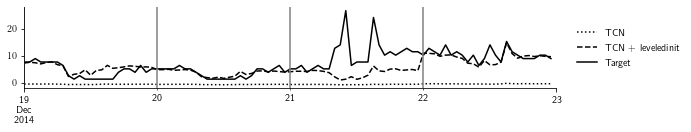

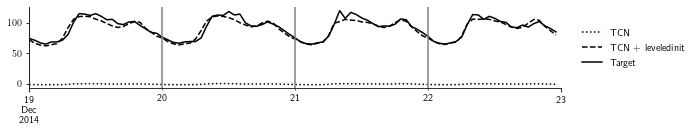

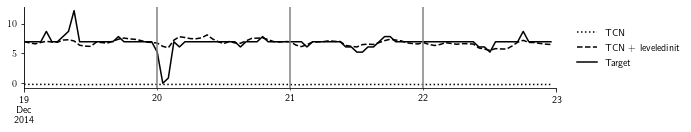

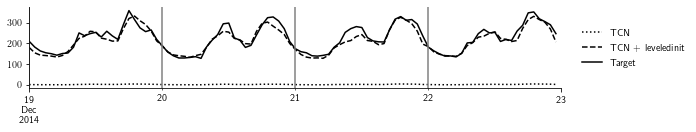

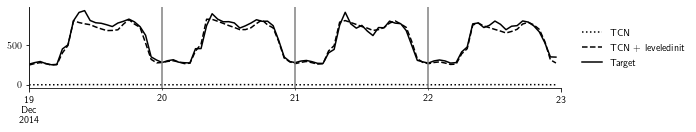

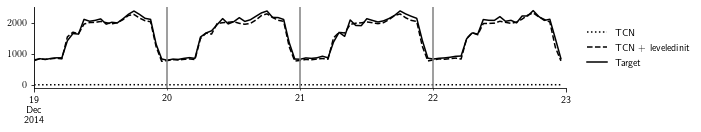

In [218]:
plot_length = 96
with plt.style.context(ts_style):
    for i in range(len(ids)): 
        ax = dfs[i][-plot_length:].plot(figsize=(2*4.77, 1.5), legend=True, color=['k', 'k', 'k'], style=[':', '--', '-'])
        x = pd.date_range(start="2014-12-16", freq="D", periods=7)
        for xc in x:
            ax.axvline(x=xc, color='grey', linestyle='-')
        x1, x2 = ax.get_xlim()
        ax.set_xlim((x1, x2 + 1))
        ax.legend(["TCN", "TCN + leveledinit", "Target"], loc=7, frameon=False, bbox_to_anchor=(1.25, 0.5))
        plt.savefig(f"Figures\pred_id_{ids[i]}.pdf", bbox_inches="tight")

# Plot representation from models

In [29]:
model_dir = "Z:\TCN_clone\TCN\electricity\models"
model_names = [
    "e94106c6db6e44c88e497fe5062c0afd",
    "ce17bfb7d3594816a20faa55795a8084",
    "d48d5f0d9bb04edda06f7e3a532b1370",
    "192a0d0d02d146dfb3148b7af4e10c19",
    "0e61357a42ee434abd1c5fe170f3f2f4",
    "ee140872041044898f7cd02412975459",
    "b0dccaa25461401bb7c8e4daade97c79",
    "81f27dc04c334908a01ec85f6671ef17"
]
model_paths = [f"{os.path.join(model_dir, mn)}.pt" for mn in model_names]
model_paths

['Z:\\TCN_clone\\TCN\\electricity\\models\\e94106c6db6e44c88e497fe5062c0afd.pt',
 'Z:\\TCN_clone\\TCN\\electricity\\models\\ce17bfb7d3594816a20faa55795a8084.pt',
 'Z:\\TCN_clone\\TCN\\electricity\\models\\d48d5f0d9bb04edda06f7e3a532b1370.pt',
 'Z:\\TCN_clone\\TCN\\electricity\\models\\192a0d0d02d146dfb3148b7af4e10c19.pt',
 'Z:\\TCN_clone\\TCN\\electricity\\models\\0e61357a42ee434abd1c5fe170f3f2f4.pt',
 'Z:\\TCN_clone\\TCN\\electricity\\models\\ee140872041044898f7cd02412975459.pt',
 'Z:\\TCN_clone\\TCN\\electricity\\models\\b0dccaa25461401bb7c8e4daade97c79.pt',
 'Z:\\TCN_clone\\TCN\\electricity\\models\\81f27dc04c334908a01ec85f6671ef17.pt']

In [34]:
models = []
for MODEL_PATH in model_paths:
    args = pickle.load(open(f"{MODEL_PATH}__args.pkl", "rb"))
    model = TCN(
        num_layers=args.num_layers,
        in_channels=1,
        out_channels=1,
        residual_blocks_channel_size=[args.res_block_size]*args.num_layers,
        kernel_size=args.kernel_size,
        bias=args.bias,
        dropout=args.dropout,
        stride=1,
        leveledinit=args.leveledinit,
        embedding_dim=args.embedding_dim,
        embed=args.embed,
    )
    model.load_state_dict(torch.load(MODEL_PATH, map_location="cpu"))
    model.eval()
    models.append(model)
#print(models)

## Embedding layer of each model

In [37]:
embeddings = []
for model in models:
    ids = [i for i in range(370)]
    ids = torch.LongTensor(ids).to("cpu")
    embds = model.embedding(ids).detach().cpu().numpy()
    embeddings.append(embds)

## Visualize

In [53]:
mystyle = {
    "axes.spines.left": False,
    "axes.spines.right": False,
    "axes.spines.bottom": False,
    "axes.spines.top": False,
    "axes.grid": False,
    "xtick.bottom": False,
    "ytick.left": False,
}

In [57]:
with plt.style.context(mystyle):
    for embedding in embeddings[:2]:
        nc = embedding.shape[1]
        if embedding.shape[1] > 2:
            tsne = TSNE(n_components=2)
            embedding = tsne.fit_transform(embedding)
        #plt.figure()
        #plt.scatter(embedding[:,0], embedding[:,1], c="#00B0F0", edgecolor="black", linewidth=0.5)
        #plt.title(f"Embedding dim {nc}")
        #plt.show()
#"colors = ["#FFC000", "#00B0F0"]ø

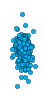

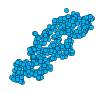

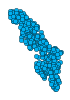

In [76]:
size=4.77/3
with plt.style.context(mystyle):
    plt.figure(figsize=(size, size))
    plt.scatter(embeddings[0][:,0], embeddings[0][:,1], s=20, c="#00B0F0", edgecolor="black", linewidth=0.3)
    plt.xticks([])
    plt.yticks([])
    plt.axis('scaled')
    #plt.title(f"Embedding dim {nc}")
    plt.savefig("electricity_learned_embedding_2.pdf")#, bbox_inches="tight")
    for embedding in embeddings[:2]:
        nc = embedding.shape[1]
        tsne = TSNE(n_components=2)
        embedding = tsne.fit_transform(embedding)
        plt.figure(figsize=(size, size))
        plt.scatter(embedding[:,0], embedding[:,1], s=20, c="#00B0F0", edgecolor="black", linewidth=0.3)
        plt.xticks([])
        plt.yticks([])
        plt.axis('scaled')
        #plt.title(f"Embedding dim {nc}")
        plt.savefig(f"electricity_learned_embedding_{nc}_tsne.pdf")#, bbox_inches="tight")

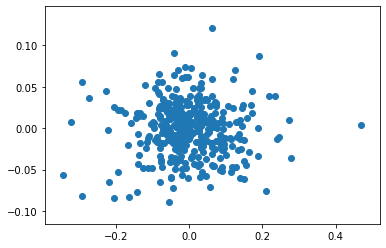

In [59]:
from sklearn.decomposition import PCA
pca = PCA(2)
embds = pca.fit_transform(embeddings[1])
plt.scatter(embds[:,0], embds[:,1])

In [25]:
s = """
e94106c6db6e44c88e497fe5062c0afd
ce17bfb7d3594816a20faa55795a8084
d48d5f0d9bb04edda06f7e3a532b1370
192a0d0d02d146dfb3148b7af4e10c19
0e61357a42ee434abd1c5fe170f3f2f4
ee140872041044898f7cd02412975459
b0dccaa25461401bb7c8e4daade97c79
81f27dc04c334908a01ec85f6671ef17
"""
s.replace("\n", "\",\"")

'","e94106c6db6e44c88e497fe5062c0afd","ce17bfb7d3594816a20faa55795a8084","d48d5f0d9bb04edda06f7e3a532b1370","192a0d0d02d146dfb3148b7af4e10c19","0e61357a42ee434abd1c5fe170f3f2f4","ee140872041044898f7cd02412975459","b0dccaa25461401bb7c8e4daade97c79","81f27dc04c334908a01ec85f6671ef17","'